In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import numpy as np
import pprint
from procedures import dump_live_config, utc_ms, make_get_filepath
from pure_funcs import (
    numpyize,
    denumpyize,
    live_config_dict_to_list_recursive_grid,
    sort_dict_keys,
    config_pretty_str,
    candidate_to_live_config,
    flatten_dict,
    ts_to_date_utc,
)
import matplotlib.pyplot as plt
from collections import OrderedDict

using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
def calc_dist(p0, p1):
    return ((p0[0] - p1[0]) ** 2 + (p0[1] - p1[1]) ** 2) ** 0.5


def dominates_d(x, y, higher_is_better):
    """Check if point x dominates point y."""
    better_in_one = False
    for xi, yi, hib in zip(x, y, higher_is_better):
        if hib:
            if xi > yi:
                better_in_one = True
            elif xi < yi:
                return False
        else:
            if xi < yi:
                better_in_one = True
            elif xi > yi:
                return False
    return better_in_one


def calc_pareto_front_d(objectives: dict, higher_is_better: [bool]):
    sorted_keys = sorted(
        objectives,
        key=lambda k: [
            -objectives[k][i] if higher_is_better[i] else objectives[k][i]
            for i in range(len(higher_is_better))
        ],
    )
    pareto_front = []

    for kcandidate in sorted_keys:
        # Assume candidate is not dominated initially
        is_dominated = False
        for kmember in pareto_front:
            if dominates_d(objectives[kmember], objectives[kcandidate], higher_is_better):
                is_dominated = True
                break
        if not is_dominated:
            # Remove any members of the pareto_front that are dominated by the candidate
            pareto_front = [
                kmember
                for kmember in pareto_front
                if not dominates_d(objectives[kcandidate], objectives[kmember], higher_is_better)
            ]
            pareto_front.append(kcandidate)
    return pareto_front

In [5]:
# location of 'all_results.txt' file from multisymbol opt
with open("results_multi/2024-04-14T16_54_48_all_results.txt") as f:
    lines = [x.strip() for x in f.readlines()]
print(f"n backtests: {len(lines)}")

n backtests: 25100


In [6]:
xs = [json.loads(x) for x in lines if x]
res = pd.DataFrame([flatten_dict(x) for x in xs])

worst_drawdown_lower_bound = res.iloc[0].args_worst_drawdown_lower_bound
print("worst_drawdown_lower_bound", worst_drawdown_lower_bound)

# choose two metrics for pareto front.
# choices:
# [w_adg_weighted, w_drawdowns_daily_mean, w_loss_profit_ratio, w_price_action_distance_mean, w_sharpe_ratio]
# for all "w_" metrics, lower is better.
# w_metric = max(worst_drawdown_lower_bound, worst_drawdown) - worst_drawdown_lower_bound) * 10 {+/-} metric
keys, higher_is_better = ["w_adg_weighted", "w_sharpe_ratio"], [False, False]
keys = ["analysis_" + key for key in keys]
candidates = res[res.analysis_worst_drawdown <= worst_drawdown_lower_bound][keys]
print("n candidates", len(candidates))
pareto = candidates.loc[
    calc_pareto_front_d({i: x for i, x in zip(candidates.index, candidates.values)}, higher_is_better)
]

# normalize and find distances to ideal point
cands_norm = (candidates - candidates.min()) / (candidates.max() - candidates.min())
pareto_norm = (pareto - candidates.min()) / (candidates.max() - candidates.min())
dists = [calc_dist(p, [float(x) for x in higher_is_better]) for p in pareto_norm.values]
pareto_w_dists = pareto_norm.join(pd.Series(dists, name="dists", index=pareto_norm.index))
closest_to_ideal = pareto_w_dists.sort_values("dists")
best = closest_to_ideal.dists.idxmin()
print("best")
print(candidates.loc[best])
print("pareto front:")
pareto.loc[closest_to_ideal.index]

worst_drawdown_lower_bound 0.5
n candidates 20819
best
analysis_w_adg_weighted   -0.0035774858
analysis_w_sharpe_ratio   -0.1243379359
Name: 24734, dtype: float64
pareto front:


,analysis_w_adg_weighted,analysis_w_sharpe_ratio
24734,-0.0035774858,-0.1243379359
24893,-0.0035774858,-0.1243379359
24754,-0.0035774858,-0.1243379359
24599,-0.0035774858,-0.1243379359
24223,-0.0035774858,-0.1243379359
...,...,...
23540,-0.0025285622,-0.1392887188
23508,-0.0025285622,-0.1392887188
25082,-0.0025285622,-0.1392887188
24783,-0.0025285622,-0.1392887188


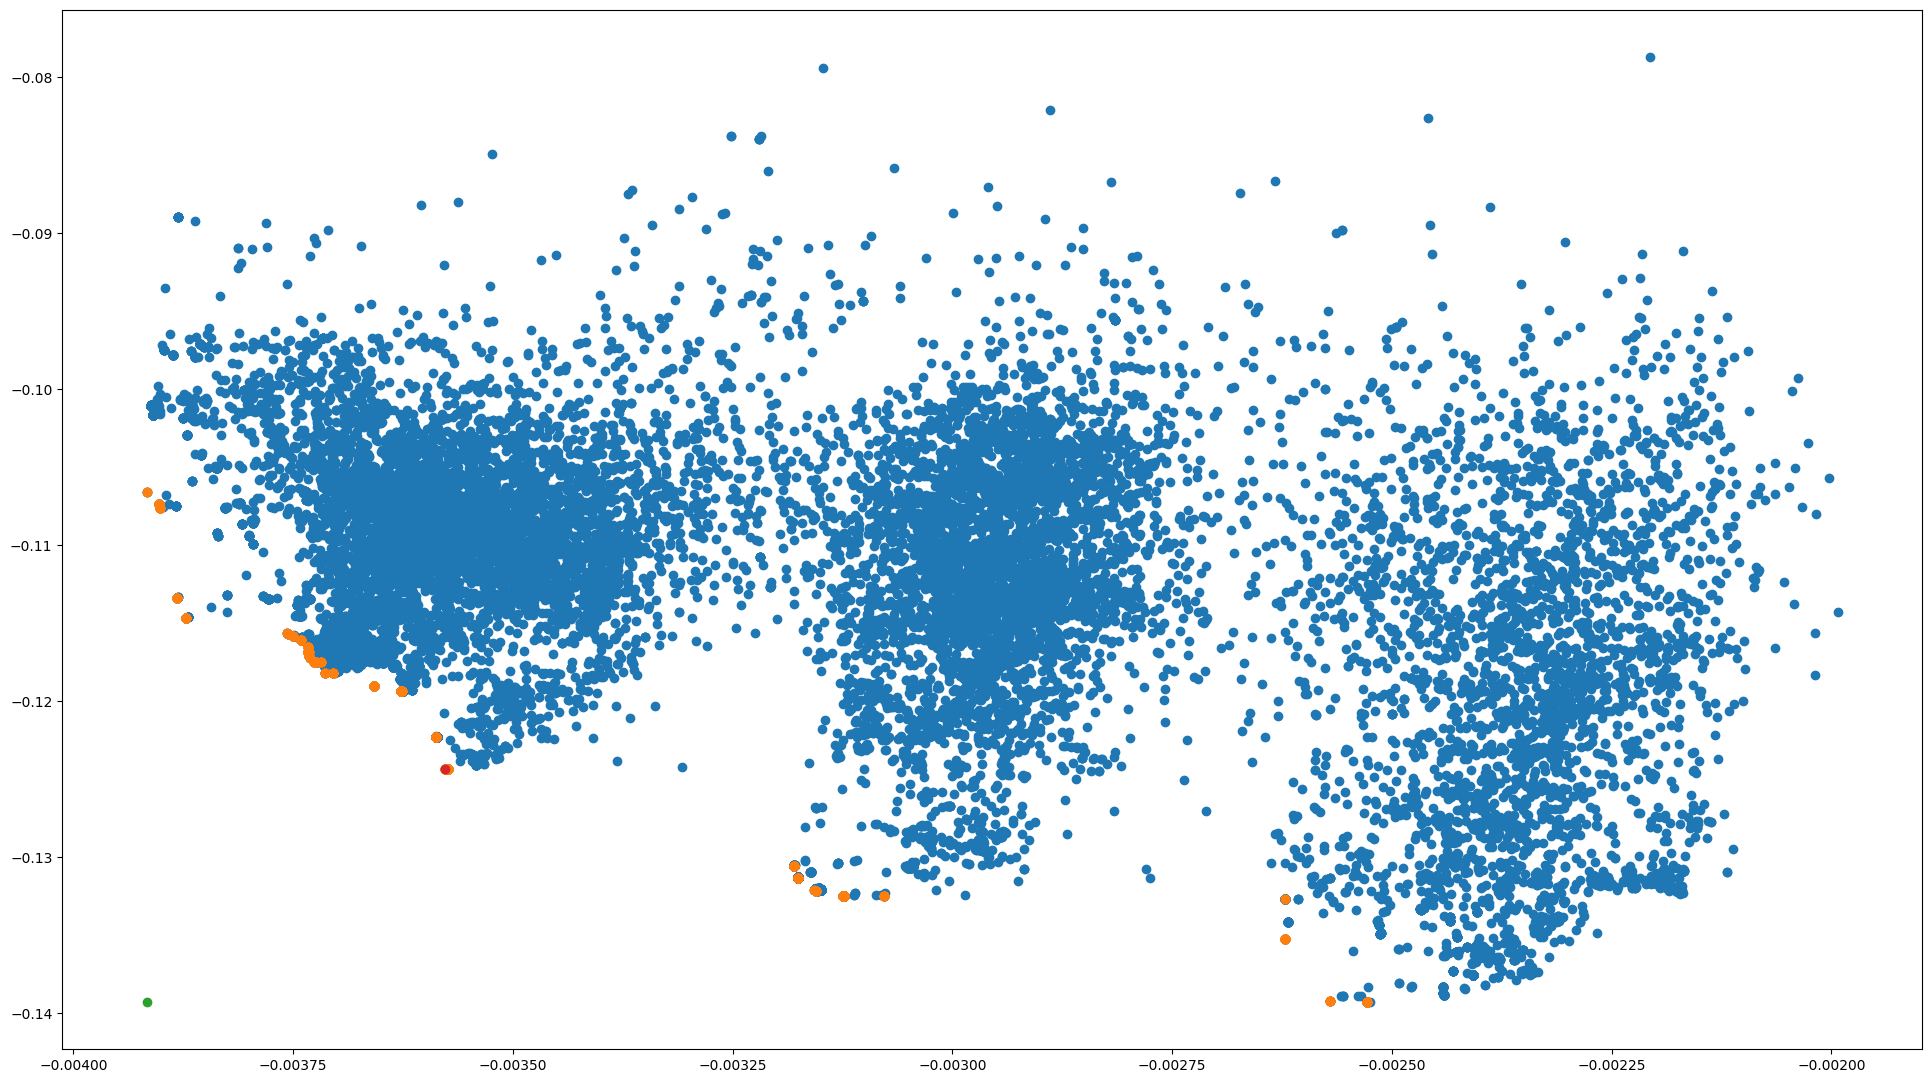

In [7]:
# scatterplot all candidates in blue, pareto front in orange, ideal target in green, closest to ideal in red
plt.scatter(*candidates.values.T)
plt.scatter(*pareto.values.T)
plt.scatter(*pareto.min().values.T)
plt.scatter(*pareto.loc[best].T)

In [8]:
ts_to_date_utc(utc_ms())[:19].replace(":", "_")

'2024-04-15T06_47_25'

In [9]:
# config from best result
best_d = xs[best]

# cfg = best_d['position']
cfg = best_d["live_config"]
cfg["long"]["wallet_exposure_limit"] = cfg["global"]["TWE_long"] / len(best_d["args"]["symbols"])
cfg["short"]["wallet_exposure_limit"] = cfg["global"]["TWE_short"] / len(best_d["args"]["symbols"])
cfg["long"]["enabled"] = best_d["args"]["long_enabled"]
cfg["short"]["enabled"] = best_d["args"]["short_enabled"]
fjson = json.dumps(best_d, indent=4, sort_keys=True)
print(fjson)
# best_d['args']['worst_drawdown_lower_bound'] = 0.25
coins = "".join([s.replace("USDT", "") for s in best_d["args"]["symbols"]])
coins = [s.replace("USDT", "") for s in best_d["args"]["symbols"]]
fname = ts_to_date_utc(utc_ms())[:19].replace(":", "_")
fname += "_" + ("_".join(coins) if len(coins) <= 5 else f"{len(coins)}_coins") + ".json"
full_path = make_get_filepath(os.path.join("results_multi_analysis", fname))
json.dump(best_d, open(full_path, "w"), indent=4, sort_keys=True)

{
    "analysis": {
        "adg": 0.002223187249141283,
        "adg_weighted": 0.0035774858460818084,
        "drawdowns_daily_mean": 0.019002722577603937,
        "loss_profit_ratio": 0.18478852838242618,
        "loss_profit_ratio_long": 0.18478852838242618,
        "loss_profit_ratio_short": 1.0,
        "n_days": 1080,
        "pnl_ratio_long_short": 1.0,
        "price_action_distance_mean": 0.050254088235051814,
        "sharpe_ratio": 0.12433793587526983,
        "w_adg_weighted": -0.0035774858460818084,
        "w_drawdowns_daily_mean": 0.019002722577603937,
        "w_loss_profit_ratio": 0.18478852838242618,
        "w_price_action_distance_mean": 0.050254088235051814,
        "w_sharpe_ratio": -0.12433793587526983,
        "worst_drawdown": 0.4763228213501847
    },
    "args": {
        "end_date": "2024-04-14",
        "exchange": "binance",
        "long_enabled": true,
        "short_enabled": false,
        "start_date": "2021-05-01",
        "starting_balance": 10000,